In [55]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
#read all the workds
words = open('names.txt', 'r').read().splitlines()
words[:8] #test print


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [57]:
len(words)

32033

In [58]:
# build mapppings of char and to integers 
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In the code, `X` and `Y` represent the inputs and targets (or labels) for training a model on character sequences. Let’s break down their purpose and shapes:

### 1. **`X` (Input Sequences)**
   - **Meaning**: `X` is a tensor containing sequences of character indices that serve as context for predicting the next character.
   - **Shape**: `(32, 3)`, which means it has 32 sequences (examples) and each sequence is of length 3.
   - **Explanation**: Each row in `X` represents a context of 3 characters (indices) that the model uses to predict the next character in the sequence. The `block_size = 3` variable determines the context length, which is why each sequence is 3 characters long.

### 2. **`Y` (Target Characters)**
   - **Meaning**: `Y` is a tensor containing the target characters (indices) that the model should predict given the context in `X`.
   - **Shape**: `(32,)`, meaning it has 32 target indices, one for each sequence in `X`.
   - **Explanation**: Each entry in `Y` corresponds to the next character (index) that follows the 3-character context in `X`. For example, if a row in `X` represents the sequence `[3, 5, 7]`, the corresponding value in `Y` would be the index of the character that comes after this sequence.

### Summary of Their Relationship
Each row in `X` provides a context of 3 characters (indices) to the model, and the corresponding entry in `Y` is the target character the model is supposed to predict. The idea is to train the model to take a context window of 3 characters and output the next character, learning to predict character sequences.


In [59]:

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
# for w in words:
# shorter test set
for w in words[:5]:
  
  print(w)
  context = [0] * block_size #note that 0 maps to ., . is used for padding
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [60]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

#### Sidenote about the "Magic number" 32
32 appears because we have generated 32 pairs of the data in X and Y, when we choose to train based on the first 5 words, they're 32 pairs of 3 chars + the correct answer

In [61]:
C = torch.randn((27,2))
C # initialize for word embeddings??

tensor([[ 0.5665,  0.6787],
        [-0.1576,  1.2216],
        [-0.6527,  0.7516],
        [-1.7996,  1.5748],
        [-2.2469, -0.9360],
        [-0.6304, -0.9013],
        [ 0.3092,  1.6223],
        [ 2.1740, -0.5561],
        [ 2.1532, -0.5143],
        [-0.3196,  0.1615],
        [ 1.4458, -1.0911],
        [ 0.3355, -0.8319],
        [-0.3411,  0.9453],
        [-2.0746,  0.0891],
        [ 0.6258,  0.7816],
        [ 1.7867,  1.2256],
        [-0.6706,  0.7014],
        [-0.1201,  0.8348],
        [ 0.3983,  0.6888],
        [-0.6277, -0.1720],
        [ 0.5206,  0.5571],
        [-0.8396, -1.3879],
        [-0.5461, -0.5061],
        [ 0.0211,  0.5332],
        [-0.5309,  0.1051],
        [ 1.2984, -0.4545],
        [ 0.6203, -0.2526]])

In [62]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [63]:
w1 = torch.randn(6, 100)
b1 = torch.randn(100)

### Transforming the embedded matrix into the corret shape so to input int the neural net

note that the 2 blocks below are equil, however the useage of .view() is much more efficient as it simply modifies how the long list of bytes is read, hence changing the shape of the tensor
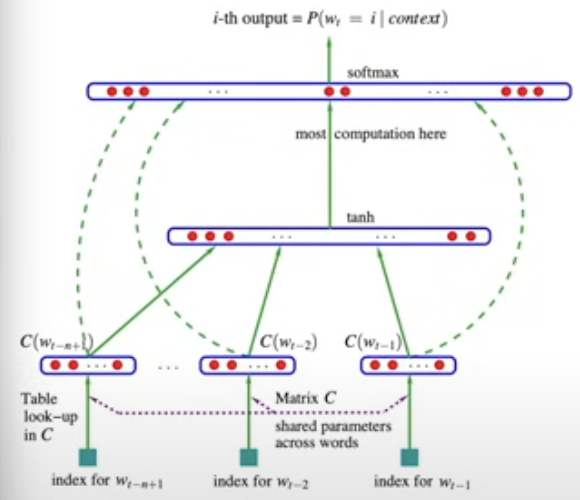

In [64]:
torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], 1).size()
# this is hella inefficient


torch.Size([32, 6])

In [65]:
h = emb.view(-1, 6) @ w1 + b1 # -1 means pytorch will derive the size
h

tensor([[  0.6126,   0.8730,  -3.9720,  ...,   1.1398,  -0.7214,  -1.5483],
        [ -2.7143,  -0.2585,  -1.8500,  ...,  -1.8388,  -0.9720,   2.3065],
        [  3.6007,   0.8925,   1.1443,  ...,  -4.6380,  -5.1253,  -0.6062],
        ...,
        [ -0.4167,   3.9671, -12.7651,  ...,   3.3485,  -1.8178,   1.4840],
        [ -3.3536,  -1.9289,  -0.6352,  ...,  -1.7524,   0.1114,   1.0494],
        [  6.2952,   2.2528,  -3.2742,  ...,   0.1535,  -1.1955,  -5.8027]])

In [66]:
h = torch.tanh(emb.view(-1, 6) @ w1 + b1) #squishing all values to be between -1 and 1
h.shape # this gives us the first activation layer 

torch.Size([32, 100])

In [67]:
b1.shape
# broadcasting, we add the same bias factor to all the rows

torch.Size([100])

## Creating the top layer
we first initialize the top layer with arbritrary weighs and biases, then we apply the softmax function to get the probrability distribution, this should sum to 1, given by prob[0]
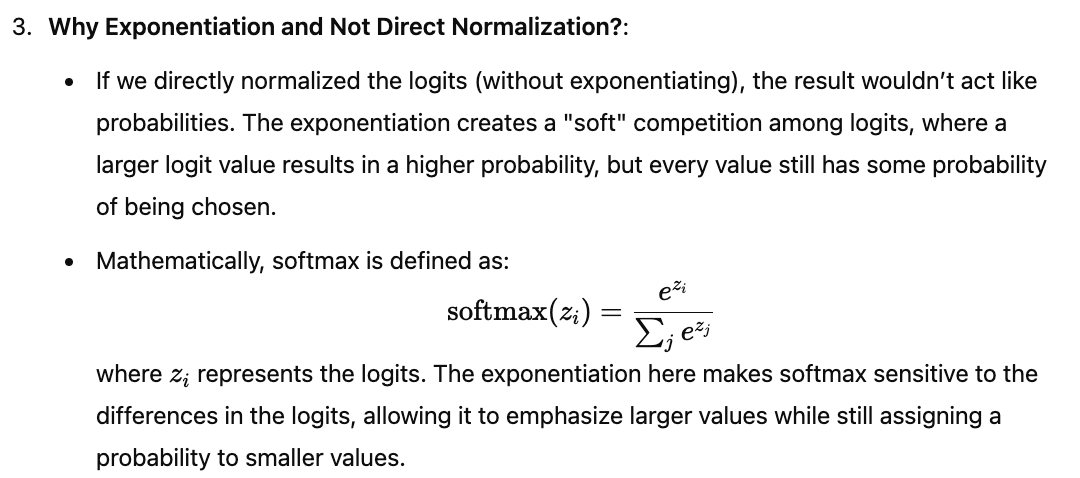

In [68]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
# final layer for output
# 27 possible outputs

In [69]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [70]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob[0].sum()
prob[0].shape # one for each possible next letter, == 27
# all thr prob on the softmax layer is now normalized and summed tgt

torch.Size([27])

****
### Cleaned up code of the above defined variables, weights etc

In [71]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [72]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [73]:
## Forward Pass

emb = C[X] # [32, 3, 2]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # [32, 100]
logits = h @ W2 + b2 # this should result in a [32, 27] matrix 

## Softmax function
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdim=True)
# loss = -prob[torch.arange(32), Y].log().mean()

## use in built function which is more efficient, this method does not create intermediate tensors
loss = F.cross_entropy(logits, Y)
loss


tensor(17.7697)

## Using cross_entropy() vs coding own softmax function

- protect against overflow
    when logits grows larger which can happen during training, exp(logits) often can run out of range in the float, cross_entropy() fixes that by ensure no overflow (normazlizing to 0) 
- Has more efficient backprop
- Better forward pass as it doesnt create so many tensors as everything is grouped up

# Running the full dataset
*** 

In [74]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [75]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g) # 10 d embedding
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [76]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [77]:
for p in parameters:
  p.requires_grad = True
# need to initlaize with everything requiring gradient for the fwd pass to calc gradient,

In [78]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [79]:
lri = []
lossi = []
stepi = []

In [ ]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01 #lower the learning rate as time passes
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

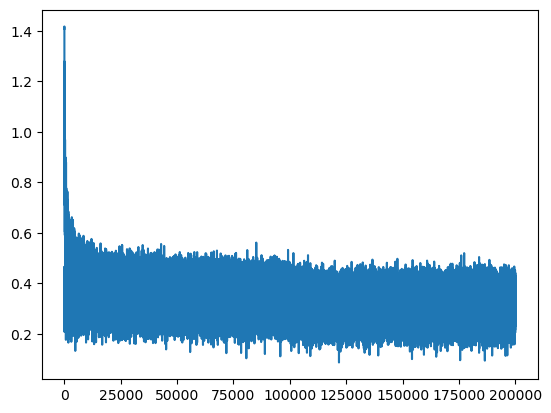

In [87]:
plt.plot(stepi, lossi)

In [88]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0747, grad_fn=<NllLossBackward0>)

In [95]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1378, grad_fn=<NllLossBackward0>)

In [96]:
loss

tensor(2.1378, grad_fn=<NllLossBackward0>)

## Embeddings is a "bottleneck" for the tanh layer, so lets increase the dimensions from the inital 2 to 10

note that the visualisation only works for a 2d embeddings, in 10d the embeddings can carry more meaning but are much harder to visualize

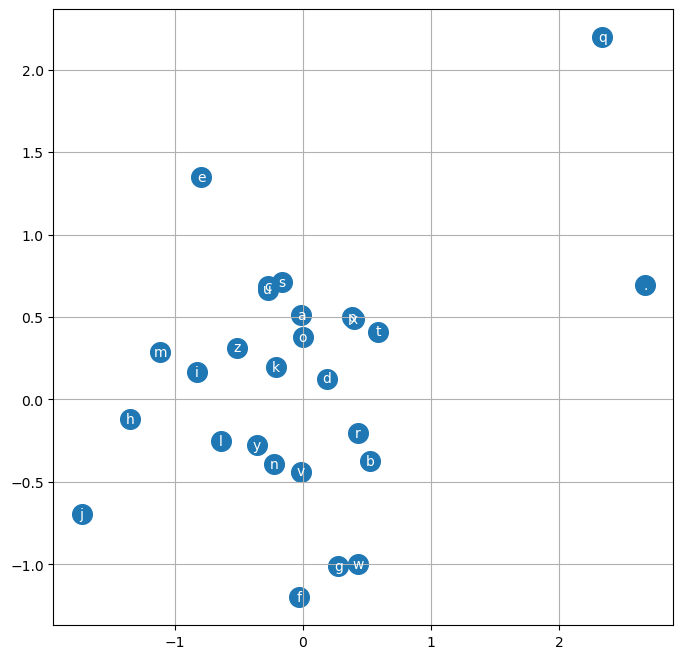

In [93]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters 
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')